In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os

# List the contents of My Drive
drive_path = '/content/drive/My Drive/'
files = os.listdir(drive_path)
print(files)

['Contacts.vcf', 'Innovation Proposal Research Topic.gdoc', 'Innovation_Proposal_Presentation_Slides.gslides', 'Library_Research_Report_Brandon_Leblanc.pdf', 'Tutorial_Proposal_Outline.gdoc', "Innovation_Proposal_Brandon-Leblanc-40058666_Karim-Hanna-40245600_Adriano-D'Ermo-40246394_Alessandro-Antonacci-4024560.gdoc", 'Colab Notebooks', 'COMP433_Lab2_Ex.ipynb', 'Untitled document.gdoc', 'COMP433_proposal.gdoc', 'mask2former_tissue_segmentation_epoch5_batch8']


In [2]:
import zipfile

# Path to the ZIP file in Google Drive
zip_file_path = '/content/drive/My Drive/Colab Notebooks/data.zip'


# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/Huron_data')

In [3]:
from transformers import Mask2FormerForUniversalSegmentation, Mask2FormerImageProcessor
import torch
import gc

def clear_model_and_cache():
    """Utility function to delete existing model and optimizer objects and clear GPU memory."""
    if 'model' in globals():
        print("Deleting existing model...")
        del globals()['optimizer']
    gc.collect()
    torch.cuda.empty_cache()

# Clear any existing model and cache

# clear_model_and_cache()

# Load the image processor with relevant settings
image_processor = Mask2FormerImageProcessor.from_pretrained(
    "facebook/mask2former-swin-base-IN21k-ade-semantic",
    do_rescale=True,   # Skip rescaling if images are already normalized
    do_normalize=True,  # Normalize images if needed
    do_resize=True     # Skip resizing as we're handling this during preprocessing
)

# Load the Mask2Former model for binary segmentation
model = Mask2FormerForUniversalSegmentation.from_pretrained(
    "facebook/mask2former-swin-base-IN21k-ade-semantic",
    num_labels=2,                     # Binary segmentation (background and tissue)
    ignore_mismatched_sizes=True      # Allow resizing of model parameters if dimensions do not match
)

###############################################
# Freezing encoder backbone if desired
###############################################


# Freeze the backbone of the Mask2Former model
for name, param in model.named_parameters():
    if "encoder" in name:  # Match all layers within the encoder (backbone)
        param.requires_grad = False

# Display the trainable layers for confirmation
# Print trainable layers
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name} is trainable")
    else:
        print(f"{name} is frozen")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/538 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size'
  return func(*args, **kwargs)


config.json:   0%|          | 0.00/9.47k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/432M [00:00<?, ?B/s]

Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-base-IN21k-ade-semantic and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.pixel_level_module.encoder.embeddings.patch_embeddings.projection.weight is frozen
model.pixel_level_module.encoder.embeddings.patch_embeddings.projection.bias is frozen
model.pixel_level_module.encoder.embeddings.norm.weight is frozen
model.pixel_level_module.encoder.embeddings.norm.bias is frozen
model.pixel_level_module.encoder.encoder.layers.0.blocks.0.layernorm_before.weight is frozen
model.pixel_level_module.encoder.encoder.layers.0.blocks.0.layernorm_before.bias is frozen
model.pixel_level_module.encoder.encoder.layers.0.blocks.0.attention.self.relative_position_bias_table is frozen
model.pixel_level_module.encoder.encoder.layers.0.blocks.0.attention.self.query.weight is frozen
model.pixel_level_module.encoder.encoder.layers.0.blocks.0.attention.self.query.bias is frozen
model.pixel_level_module.encoder.encoder.layers.0.blocks.0.attention.self.key.weight is frozen
model.pixel_level_module.encoder.encoder.layers.0.blocks.0.attention.self.key.bias is frozen
model.pixel_level

In [5]:
import os
import numpy as np
from PIL import Image, ImageEnhance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch


# Define paths (update these paths based on where you extracted the files)
image_folder = os.path.join("/content/Huron_data/data/Huron_data/", "Sliced_Images")
mask_folder = os.path.join("/content/Huron_data/data/Huron_data/", "Sliced_masks")


# Get sorted lists of image and mask files
image_files = [os.path.join(image_folder, f) for f in sorted(os.listdir(image_folder))]
mask_files = [os.path.join(mask_folder, f) for f in sorted(os.listdir(mask_folder))]

# Ensure matching number of images and masks
assert len(image_files) == len(mask_files), "Mismatch between image and mask files."

def crop_black_borders(image, threshold=30):
    """Crop black borders from an image based on a threshold for black pixels."""
    img_array = np.array(image)
    gray_img = np.mean(img_array, axis=2)  # Convert to grayscale by averaging channels

    # Initialize cropping boundaries
    top, bottom = 0, gray_img.shape[0]
    left, right = 0, gray_img.shape[1]

    # Crop from the top
    while top < bottom and np.mean(gray_img[top, :]) <= threshold:
        top += 1

    # Crop from the bottom
    while bottom > top and np.mean(gray_img[bottom - 1, :]) <= threshold:
        bottom -= 1

    # Crop from the left
    while left < right and np.mean(gray_img[:, left]) <= threshold:
        left += 1

    # Crop from the right
    while right > left and np.mean(gray_img[:, right - 1]) <= threshold:
        right -= 1

    # Crop the image to the calculated bounds
    cropped_image = image.crop((left, top, right, bottom))
    return cropped_image

def preprocess_image(image_path, target_size=(128, 128)):
    """Preprocess an image: crop black borders, enhance contrast, and resize."""
    image = Image.open(image_path).convert("RGB")
    cropped_image = crop_black_borders(image)

    # Resize to the target size
    resized_image = cropped_image.resize(target_size, Image.BICUBIC)

    return resized_image


def preprocess_mask(mask_path, target_size=(128, 128)):
    """Convert mask to binary, ensure tissue is white and background is black, and resize."""
    mask = Image.open(mask_path).convert("L")  # Convert mask to grayscale
    mask_array = np.array(mask)

    # Apply binary threshold and ensure tissue is white, background is black
    binary_mask = np.where(mask_array > 0, 1, 0).astype(np.uint8)  # Normalize mask to [0, 1]
    binary_mask = Image.fromarray(binary_mask * 255)  # Convert back to PIL Image

    # Resize to the target size using nearest-neighbor interpolation
    resized_mask = binary_mask.resize(target_size, Image.NEAREST)

    return resized_mask

from torchvision import transforms

# Define transforms for images and masks
image_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize input images
    transforms.ToTensor(),  # Convert to tensor
])

mask_transform = transforms.Compose([
    transforms.Resize((128, 128), interpolation=Image.NEAREST),  # Resize masks
    transforms.ToTensor(),  # Convert to tensor
])

# Dataset class
class TissueDataset(Dataset):
    def __init__(self, image_files, mask_files, image_processor=None, mask_transform=None):
        """
        Initialize the TissueDataset.

        Parameters:
        - image_files: List of image file paths.
        - mask_files: List of mask file paths.
        - image_processor: Preprocessing function for images (expects PIL input).
        - mask_transform: Preprocessing function for masks.
        """
        self.image_files = image_files
        self.mask_files = mask_files
        self.image_processor = image_processor
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image and mask as PIL images
        image = Image.open(self.image_files[idx]).convert("RGB")  # Convert to PIL RGB
        mask = Image.open(self.mask_files[idx]).convert("L")  # Convert to PIL Grayscale
        # process images
        image = preprocess_image(self.image_files[idx])
        mask = preprocess_mask(self.mask_files[idx])
        # Process image using the image processor
        if self.image_processor:
            # Convert PIL image to tensor using the image processor
            image = self.image_processor(images=image, return_tensors="pt")["pixel_values"].squeeze(0)

        # Process the mask using mask_transform (if provided)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

# Create dataset
dataset = TissueDataset(
    image_files=image_files,
    mask_files=mask_files,
    image_processor=image_processor,  # Pass the image processor here
    mask_transform=mask_transform     # Pass the mask transform here
)

# cut dataset in half
# dataset = torch.utils.data.Subset(dataset, range(0, len(dataset)//2))
# Split dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [6]:
# print length of train and val dataset
print(len(train_dataset))
print(len(val_dataset))


13877
3470


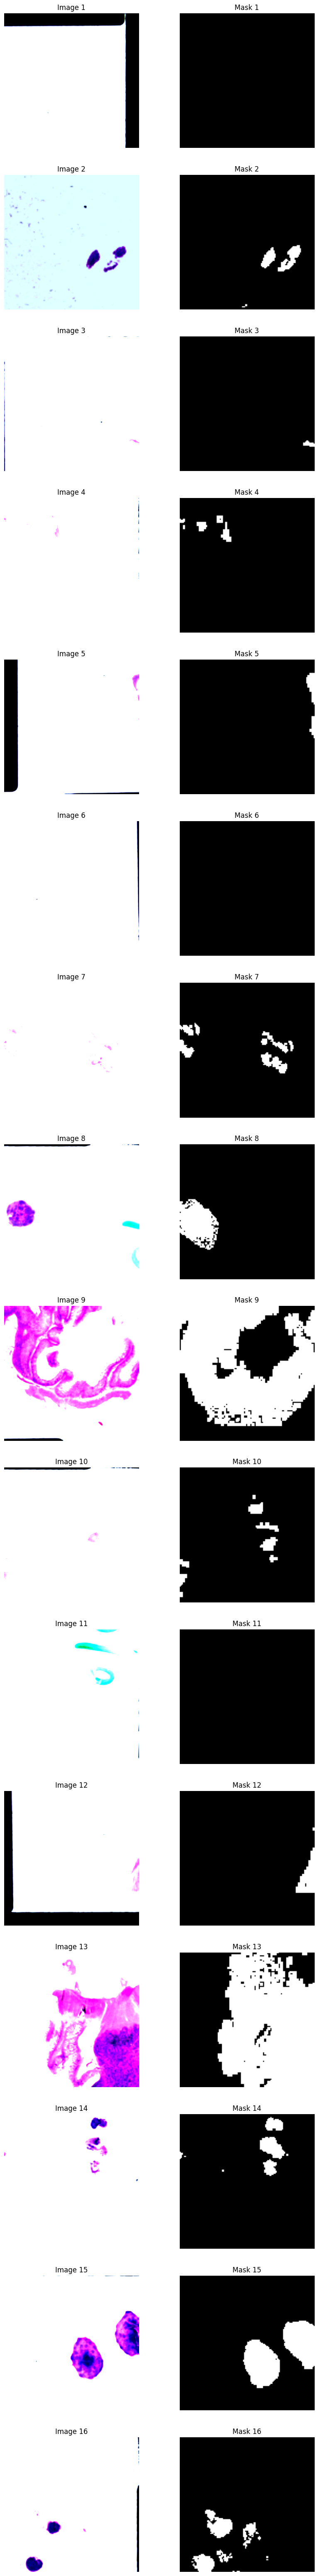

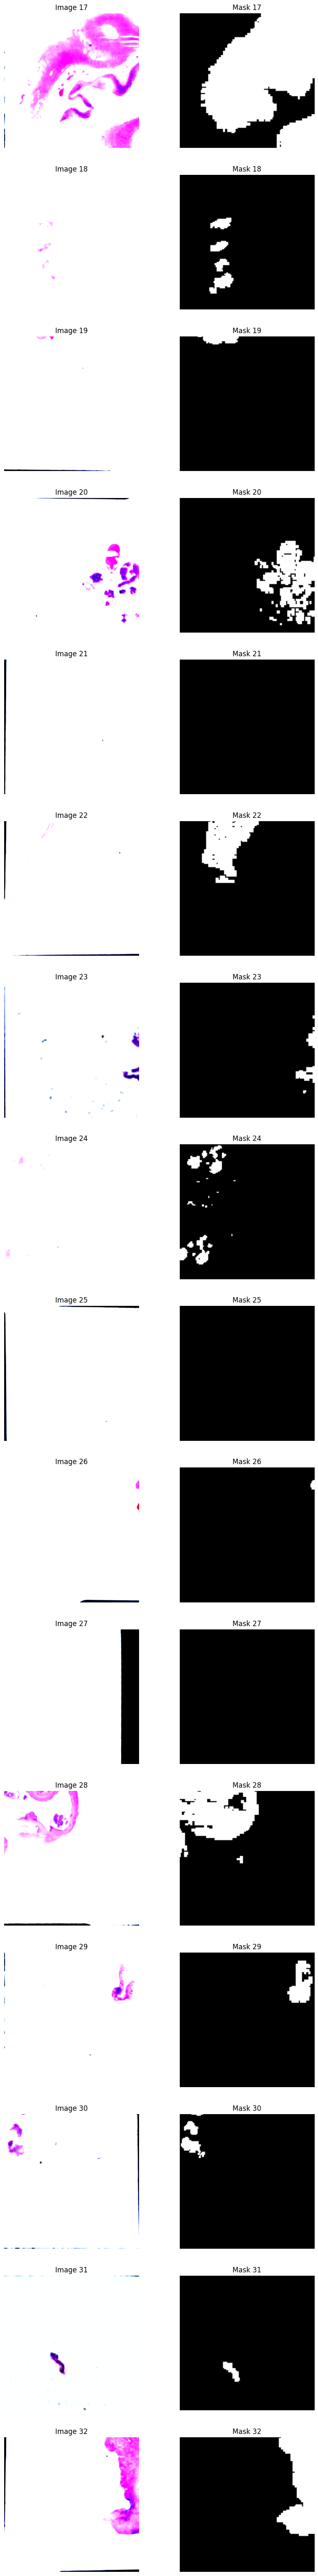

In [7]:
import matplotlib.pyplot as plt

def visualize_batch_from_loader(loader, num_batches=1):
    """Visualize a few batches of images and masks from the DataLoader."""
    loader_iter = iter(loader)

    for batch_idx in range(num_batches):
        # Get the next batch of images and masks
        images, masks = next(loader_iter)

        # Move tensors to CPU if necessary and convert to numpy
        images_np = images.permute(0, 2, 3, 1).cpu().numpy()
        masks_np = masks.squeeze(1).cpu().numpy()  # Remove channel dimension for masks

        # Display images and masks side by side
        batch_size = images_np.shape[0]
        fig, axes = plt.subplots(batch_size, 2, figsize=(10, 5 * batch_size))

        for i in range(batch_size):
            axes[i, 0].imshow(images_np[i])
            axes[i, 0].set_title(f"Image {batch_idx * batch_size + i + 1}")
            axes[i, 0].axis("off")

            axes[i, 1].imshow(masks_np[i], cmap="gray")
            axes[i, 1].set_title(f"Mask {batch_idx * batch_size + i + 1}")
            axes[i, 1].axis("off")

        plt.show()

# Use this function to visualize a few batches of images and masks from the train_loader
visualize_batch_from_loader(train_loader, num_batches=2)


In [8]:
import matplotlib.pyplot as plt
import os
from PIL import Image
from torchvision import transforms

def verify_data_alignment(dataset, image_files, num_samples=5):
    """
    Verify data processing by displaying original images, preprocessed images, and processed masks.

    Args:
        dataset: The dataset object that provides preprocessed images and masks.
        image_files: A list of full paths to the original image files.
        num_samples: Number of samples to visualize.
    """
    for i in range(num_samples):
        # Retrieve the preprocessed image and mask from the dataset
        preprocessed_image, processed_mask = dataset[i]

        # Convert tensors to PIL images for visualization
        preprocessed_image_pil = transforms.ToPILImage()(preprocessed_image)
        processed_mask_pil = transforms.ToPILImage()(processed_mask)

        # Load the original image (image_files already contains the full path)
        original_image = Image.open(image_files[i]).convert("RGB")

        # Display the original image, preprocessed image, and processed mask side by side
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        axs[0].imshow(original_image)
        axs[0].set_title(f"Original Image {i + 1}")
        axs[0].axis("off")

        axs[1].imshow(preprocessed_image_pil)
        axs[1].set_title(f"Preprocessed Image {i + 1}")
        axs[1].axis("off")

        axs[2].imshow(processed_mask_pil, cmap="gray")
        axs[2].set_title(f"Processed Mask {i + 1}")
        axs[2].axis("off")

        plt.show()

# Run the verification for the first few images and masks
verify_data_alignment(dataset, image_files=image_files, num_samples=10)

Output hidden; open in https://colab.research.google.com to view.

In [9]:
import torch.nn as nn

class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # Apply sigmoid to inputs if not already done
        inputs = torch.sigmoid(inputs)

        # Flatten
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice




In [15]:
def calculate_iou_infer(predicted_mask, ground_truth_mask):
    """
    Calculate Intersection over Union (IoU) between the predicted mask and the ground truth mask.

    Args:
        predicted_mask (numpy.ndarray): Binary predicted mask (0 or 1).
        ground_truth_mask (numpy.ndarray): Binary ground truth mask (0 or 1).

    Returns:
        float: IoU score.
    """
    intersection = np.logical_and(predicted_mask, ground_truth_mask).sum()
    union = np.logical_or(predicted_mask, ground_truth_mask).sum()
    return intersection / union if union > 0 else 0.0

def calculate_dice_infer(predicted_mask, ground_truth_mask):
    """
    Calculate Dice Coefficient between the predicted mask and the ground truth mask.

    Args:
        predicted_mask (numpy.ndarray): Binary predicted mask (0 or 1).
        ground_truth_mask (numpy.ndarray): Binary ground truth mask (0 or 1).

    Returns:
        float: Dice Coefficient score.
    """
    intersection = np.logical_and(predicted_mask, ground_truth_mask).sum()
    return (2 * intersection) / (predicted_mask.sum() + ground_truth_mask.sum()) if (predicted_mask.sum() + ground_truth_mask.sum()) > 0 else 0.0



In [11]:
import torch.nn as nn
# combined dice and BCE loss function
# Define Combined Dice and BCE Loss
class CombinedDiceBCELoss(nn.Module):
    def __init__(self, dice_weight=0.5, bce_weight=0.5, smooth=1e-6):
        super(CombinedDiceBCELoss, self).__init__()
        self.dice_weight = dice_weight
        self.bce_weight = bce_weight
        self.smooth = smooth
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, logits, targets):
        # Dice Loss
        probs = torch.sigmoid(logits)
        intersection = (probs * targets).sum(dim=(1, 2))  # Sum over spatial dimensions only
        dice_loss = 1 - (2. * intersection + self.smooth) / (probs.sum(dim=(1, 2)) + targets.sum(dim=(1, 2)) + self.smooth)
        dice_loss = dice_loss.mean()  # Average over the batch

        # BCE Loss
        bce_loss = self.bce(logits, targets)

        # Combine losses
        return self.dice_weight * dice_loss + self.bce_weight * bce_loss

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from PIL import Image
import numpy as np
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# print the device
print(device)

# Move the model to the device
model.to(device)

# Set a smaller learning rate for fine-tuning
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

# Assuming DiceLoss is already defined in your environment
criterion = DiceLoss()

def train(model, train_loader, criterion, optimizer, num_epochs=5):
    """
    Training function with loss calculation.
    """
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0

        for pixel_values, masks in tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training"):
            # Move inputs and masks to the correct device
            pixel_values = pixel_values.to(device, dtype=next(model.parameters()).dtype)  # Match model dtype
            masks = masks.to(device, dtype=torch.float32)  # Ensure masks are on the correct device and float32

            # Forward pass
            outputs = model(pixel_values=pixel_values)
            tissue_logits = outputs.masks_queries_logits[:, 1]  # Binary segmentation logits

            # Resize logits to match masks
            tissue_logits_resized = F.interpolate(
                tissue_logits.unsqueeze(1),  # Add channel dimension
                size=masks.shape[-2:],  # Match mask size
                mode="bilinear",
                align_corners=False
            ).squeeze(1)  # Remove channel dimension

            # Compute loss
            loss = criterion(tissue_logits_resized, masks)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate loss
            running_loss += loss.item()

        # Average loss for the epoch
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

def validate(model, val_loader, criterion, device):
    """
    Validation function aligned with inference logic, including IoU and Dice metric calculation.

    Args:
        model: The trained segmentation model.
        val_loader: DataLoader providing validation images and ground truth masks.
        criterion: Loss function for evaluation.
        device: Computation device (CPU or CUDA).

    Returns:
        avg_val_loss: Average validation loss.
        avg_iou: Average IoU across the validation set.
        avg_dice: Average Dice score across the validation set.
    """
    model.eval()
    val_loss = 0.0
    total_iou = 0.0
    total_dice = 0.0
    num_samples = 0

    with torch.no_grad():
        for images, ground_truth_masks in tqdm(val_loader, desc="Validation"):
            # Move ground truth masks to device and convert to float
            ground_truth_masks = ground_truth_masks.to(device, dtype=torch.float32)

            # Forward pass
            outputs = model(pixel_values=images.to(device))
            tissue_logits = outputs.masks_queries_logits[:, 1]  # Binary segmentation logits

            # Resize logits to match ground truth mask size
            tissue_logits_resized = torch.sigmoid(F.interpolate(
                tissue_logits.unsqueeze(1),  # Add channel dimension
                size=ground_truth_masks.shape[-2:],  # Match mask size
                mode="bilinear",
                align_corners=False
            ).squeeze(1))  # Remove channel dimension

            # Compute loss
            loss = criterion(tissue_logits_resized, ground_truth_masks)
            val_loss += loss.item()

            # Convert predicted logits to binary masks
            predicted_masks = (tissue_logits_resized > 0.5).cpu().numpy().astype(np.uint8)
            ground_truth_masks_np = ground_truth_masks.cpu().numpy().astype(np.uint8)

            # Compute metrics
            for pred, gt in zip(predicted_masks, ground_truth_masks_np):
                total_iou += calculate_iou_infer(pred, gt)
                total_dice += calculate_dice_infer(pred, gt)
                num_samples += 1

    # Calculate average loss and metrics
    avg_val_loss = val_loss / len(val_loader)
    avg_iou = total_iou / num_samples if num_samples > 0 else 0
    avg_dice = total_dice / num_samples if num_samples > 0 else 0

    print(f"\nValidation Loss: {avg_val_loss:.4f}")
    print(f"Mean IoU: {avg_iou:.4f}")
    print(f"Mean Dice: {avg_dice:.4f}")

    return avg_val_loss, avg_iou, avg_dice


cuda


In [13]:

# Check if CUDA is available
print("CUDA Available: ", torch.cuda.is_available())

CUDA Available:  True


In [14]:
# train model on 10 epochs
train(model, train_loader, criterion, optimizer, num_epochs=10)

Epoch [1/10] Training: 100%|██████████| 868/868 [23:07<00:00,  1.60s/it]


Epoch [1/10], Loss: 0.1293


Epoch [2/10] Training: 100%|██████████| 868/868 [23:04<00:00,  1.59s/it]


Epoch [2/10], Loss: 0.1087


Epoch [3/10] Training: 100%|██████████| 868/868 [23:03<00:00,  1.59s/it]


Epoch [3/10], Loss: 0.1046


Epoch [4/10] Training: 100%|██████████| 868/868 [23:02<00:00,  1.59s/it]


Epoch [4/10], Loss: 0.1029


Epoch [5/10] Training: 100%|██████████| 868/868 [23:07<00:00,  1.60s/it]


Epoch [5/10], Loss: 0.0996


Epoch [6/10] Training: 100%|██████████| 868/868 [23:04<00:00,  1.60s/it]


Epoch [6/10], Loss: 0.0998


Epoch [7/10] Training: 100%|██████████| 868/868 [23:04<00:00,  1.60s/it]


Epoch [7/10], Loss: 0.0977


Epoch [8/10] Training: 100%|██████████| 868/868 [23:04<00:00,  1.59s/it]


Epoch [8/10], Loss: 0.0966


Epoch [9/10] Training: 100%|██████████| 868/868 [23:04<00:00,  1.59s/it]


Epoch [9/10], Loss: 0.0947


Epoch [10/10] Training: 100%|██████████| 868/868 [23:02<00:00,  1.59s/it]

Epoch [10/10], Loss: 0.0936


In [19]:
# validate the model
validate(model, val_loader, criterion, device)

Validation: 100%|██████████| 217/217 [04:25<00:00,  1.22s/it]


Validation Loss: 0.6452
Mean IoU: 0.6332
Mean Dice: 0.7160


(0.6452221376005955, 0.6331684486960448, 0.7159585426287292)

In [16]:
model.save_pretrained("/content/drive/My Drive/mask2former_tissue_segmentation_dice_epoch10_batch16")
image_processor.save_pretrained("/content/drive/My Drive/mask2former_tissue_segmentation_dice_epoch10_batch16")


['/content/drive/My Drive/mask2former_tissue_segmentation_dice_epoch10_batch16/preprocessor_config.json']

In [ ]:
# load the model
model_test = Mask2FormerForUniversalSegmentation.from_pretrained("/content/drive/My Drive/mask2former_tissue_segmentation_dice_epoch10_batch16")
image_processor_test = Mask2FormerImageProcessor.from_pretrained("/content/drive/My Drive/mask2former_tissue_segmentation_dice_epoch10_batch16")

In [ ]:
model.save_pretrained('fine-tuned-mask2former')
image_processor.save_pretrained('fine-tuned-mask2former')

['fine-tuned-mask2former/preprocessor_config.json']

In [ ]:
# load thefine tuned model
model_test = Mask2FormerForUniversalSegmentation.from_pretrained('fine-tuned-mask2former')
image_processor_test = Mask2FormerImageProcessor.from_pretrained('fine-tuned-mask2former')


In [ ]:
def calculate_iou_infer(pred, target):
    """
    Calculate Intersection over Union (IoU) between two binary masks.
    Works with NumPy arrays.
    """
    pred = (pred > 0.5).astype(np.uint8)
    target = (target > 0.5).astype(np.uint8)
    intersection = np.logical_and(pred, target).sum()
    union = np.logical_or(pred, target).sum()
    return intersection / (union + 1e-6)  # Avoid division by zero

def calculate_dice_infer(pred, target):
    """
    Calculate Dice coefficient between two binary masks.
    Works with NumPy arrays.
    """
    pred = (pred > 0.5).astype(np.uint8)
    target = (target > 0.5).astype(np.uint8)
    intersection = np.logical_and(pred, target).sum()
    return (2 * intersection) / (pred.sum() + target.sum() + 1e-6)  # Avoid division by zero

In [ ]:

import matplotlib.pyplot as plt
import torch
import numpy as np
from tqdm import tqdm
from PIL import Image


def infer_and_display(model, image_processor, dataloader, device, num_samples=5, target_size=(128, 128)):
    """
    Perform inference and display the original image, ground truth mask, and predicted mask side by side.

    Args:
        model: The trained segmentation model.
        image_processor: Preprocessing module for the input images.
        dataloader: DataLoader providing images and ground truth masks.
        device: Computation device (CPU or CUDA).
        num_samples: Number of samples to visualize.
        target_size: Target size for resizing masks during visualization.
    """
    model.eval()
    samples_displayed = 0
    total_iou = 0.0
    total_dice = 0.0
    num_evaluated = 0

    with torch.no_grad():
        for images, ground_truth_masks in tqdm(dataloader, desc="Inferencing"):
            # Move ground truth masks to device and convert to float
            ground_truth_masks = ground_truth_masks.to(device, dtype=torch.float32)

            # Convert tensors to PIL images for the image processor
            pil_images = [transforms.ToPILImage()(img) for img in images]
            inputs = image_processor(images=pil_images, return_tensors="pt")
            pixel_values = inputs["pixel_values"].to(device)

            # Forward pass
            outputs = model(pixel_values=pixel_values)
            tissue_logits = outputs.masks_queries_logits[:, 1]  # Binary segmentation logits

            # Resize logits to match mask size
            tissue_logits_resized = torch.sigmoid(F.interpolate(
                tissue_logits.unsqueeze(1),
                size=ground_truth_masks.shape[-2:],  # Match ground truth mask size
                mode="bilinear",
                align_corners=False
            ).squeeze(1))  # Remove channel dimension

            # Convert predicted logits to binary masks
            predicted_masks = (tissue_logits_resized > 0.5).cpu().numpy().astype(np.uint8)

            # Display the first few samples
            for i in range(len(images)):
                if samples_displayed >= num_samples:
                    # Print the average metrics
                    avg_iou = total_iou / num_evaluated
                    avg_dice = total_dice / num_evaluated
                    print(f"\nMean IoU: {avg_iou:.4f}")
                    print(f"\nMean Dice: {avg_dice:.4f}")
                    return

                # Convert images, ground truths, and predictions to displayable formats
                original_image = pil_images[i]
                ground_truth_mask = ground_truth_masks[i].cpu().numpy().squeeze()  # Remove extra dimensions
                predicted_mask = predicted_masks[i]

                # Ensure ground truth mask is binary (0 or 1) and scaled to 255
                ground_truth_mask = (ground_truth_mask > 0.5).astype(np.uint8) * 255

                # Calculate IoU and Dice for the current sample
                iou = calculate_iou_infer(predicted_mask, ground_truth_mask // 255)  # Divide by 255 for binary comparison
                dice = calculate_dice_infer(predicted_mask, ground_truth_mask // 255)  # Divide by 255 for binary comparison
                total_iou += iou
                total_dice += dice
                num_evaluated += 1

                # Resize ground truth and predicted masks for visualization
                ground_truth_mask_resized = np.array(Image.fromarray(ground_truth_mask).resize(target_size, Image.NEAREST))
                predicted_mask_resized = np.array(Image.fromarray((predicted_mask * 255).astype(np.uint8)).resize(target_size, Image.NEAREST))

                # Display side by side
                fig, axs = plt.subplots(1, 3, figsize=(15, 5))
                axs[0].imshow(original_image)
                axs[0].set_title(f"Original Image {samples_displayed + 1}")
                axs[0].axis("off")

                axs[1].imshow(ground_truth_mask_resized, cmap="gray", vmin=0, vmax=255)
                axs[1].set_title(f"Ground Truth Mask {samples_displayed + 1}")
                axs[1].axis("off")

                axs[2].imshow(predicted_mask_resized, cmap="gray", vmin=0, vmax=255)
                axs[2].set_title(f"Predicted Mask {samples_displayed + 1}")
                axs[2].axis("off")

                plt.show()
                samples_displayed += 1

    # Print the final average metrics
    avg_iou = total_iou / num_evaluated if num_evaluated > 0 else 0
    avg_dice = total_dice / num_evaluated if num_evaluated > 0 else 0
    print(f"\nMean IoU: {avg_iou:.4f}")
    print(f"Mean Dice: {avg_dice:.4f}")

In [ ]:
# Perform inference and display results
infer_and_display(model_test, image_processor_test, val_loader, device, num_samples=1000)

Output hidden; open in https://colab.research.google.com to view.